<a href="https://colab.research.google.com/github/h-ather/AnomalyDetection_with_VAE_and_NF/blob/main/PHYS570AI_Final_Project_Anomaly_Detection_NF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Libraries and Packages

In [ ]:
from google.colab import files
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn import metrics
from torch import optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch.distributions import MultivariateNormal
!pip install pytorch_lightning -qq
!pip install normflows
import pytorch_lightning as pl
import normflows as nf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=778f97919319f4d8b1f7a942a6ff9f11e013a08d6eaaae932f416749bcd41b9f
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


## Upload Dataset

In [ ]:
# Upload Dataset
print("Upload higgs-boson.zip dataset files")
print(" ")
print(" ")
files.upload()

Upload higgs-boson.zip dataset files
 
 


Saving higgs-boson.zip to higgs-boson.zip


In [ ]:
# unzip data to higgs-boson
! unzip higgs-boson.zip -d higgs-boson

# unzip train datas (test here is not used)
! unzip ./higgs-boson/test.zip -d ./higgs-boson/test/
! unzip ./higgs-boson/training.zip -d ./higgs-boson/training/

Archive:  higgs-boson.zip
  inflating: higgs-boson/HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: higgs-boson/random_submission.zip  
  inflating: higgs-boson/test.zip    
  inflating: higgs-boson/training.zip  
Archive:  ./higgs-boson/test.zip
  inflating: ./higgs-boson/test/test.csv  
Archive:  ./higgs-boson/training.zip
  inflating: ./higgs-boson/training/training.csv  


## Set Hyperparameters

In [ ]:
# HyperParameters

batch_size=64 # best 64
n_epochs=50
input_dim = 30  # X_train.shape[-1]
output_dim = input_dim
latent_dim=10 # best 10
layer_dims=np.array([input_dim,20,latent_dim])
stdev=0.01 # best 0.01
learning_rate=1e-2 # best 1e-2
l2_regularizer=5e-3 # best 5e-3


n_flows=2
# num_blocks=2
hidden_flow_size=10

## Data Loading

In [ ]:
# Define dataset class
class CustomDataset(Dataset):
  def __init__(self, X: Tensor, labels: Tensor):
    self.X = X
    self.Y = labels
  def __len__(self):
      return self.X.shape[0]
  def __getitem__(self, idx: int):
    x = self.X[idx]
    label = self.Y[idx]
    return x, label


# read and filter out bad values
df = pd.read_csv("./higgs-boson/training/training.csv")
df = df.drop(columns=['EventId', 'Weight']) # drop columns we don't use
df = df.replace(-999.000, np.nan)
df = df.dropna()
df.head()

# Label column is our y (output). Rest is our X (input)
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy() # just get Label
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"Y values b4 numeration: {Y}")
# turn the signal and background to 1 and 0 respectively
Y[Y == "s"] = 1
Y[Y == "b"] = 0
print(np.any(Y == "s") or np.any(Y == "b")) # check if there's any non number left
print(f"Y values after numeration: {Y}")
Y = Y.astype('int32').reshape((-1,1)) # reshape to 2D data to match our training pipeline
print(f"{Y.shape}\nY values after reshape: {Y}")



X shape: (68114, 30)
Y shape: (68114,)
Y values b4 numeration: ['s' 'b' 's' ... 's' 's' 'b']
False
Y values after numeration: [1 0 1 ... 1 1 0]
(68114, 1)
Y values after reshape: [[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [0]]


In [ ]:
Y.shape
(Y==1).shape
(np.where(Y==1))[0]

array([    0,     2,     4, ..., 68110, 68111, 68112])

In [ ]:
Y_signal = Y[Y==1]
Y_background = Y[Y==0]

signal_indices = np.where(Y==1)[0]
background_indices = np.where(Y==0)[0]

X_signal = X[signal_indices,:]
X_background = X[background_indices,:]

print(Y_signal.shape)
print(Y_background.shape)
print(X_signal.shape)
print(X_background.shape)

(31894,)
(36220,)
(31894, 30)
(36220, 30)


In [ ]:
# Creating Dataset and Defining model
# X = torch.Tensor(X)
# Y = torch.Tensor(Y)

#Train only on signal
X = torch.Tensor(X_signal)
Y = torch.Tensor(Y_signal)
X_background = torch.Tensor(X_background)
Y_background = torch.Tensor(Y_background)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

# # 25% of training is validation now
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25)

# Training Data
dataset_train = CustomDataset(X_train, Y_train)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Testing Data
dataset_test = CustomDataset(X_test, Y_test)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# # Validation Data
# dataset_val = CustomDataset(X_val, Y_val)
# val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

## Utils

### Layer of NN

In [ ]:
class Layer(nn.Module):
  # a fcn layer with activation
  def __init__(self,input_dim,output_dim):
    super().__init__()
    layers=[nn.Linear(input_dim,output_dim)]
    layers.append(nn.BatchNorm1d(output_dim))
    layers.append(nn.LeakyReLU(0.1,inplace=True))
    self.block=nn.Sequential(*layers)

  def forward(self,x):
    return self.block(x)

### Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, layer_dims,latent_dim):
    super().__init__()
    self.layers=nn.Sequential(
        *[Layer(layer_dims[i],layer_dims[i+1]) for i in range(len(layer_dims)-1)]
        )
    self.mean=nn.Linear(layer_dims[-1],latent_dim)
    self.logvar=nn.Linear(layer_dims[-1],latent_dim)

  def forward(self,x):
    h=self.layers(x)
    mu=self.mean(h)
    log_var=self.logvar(h)

    return x,mu,log_var

### Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, layer_dims,output_dim):
    super().__init__()
    layer_dims=np.flip(layer_dims)
    self.layers=nn.Sequential(
        *[Layer(layer_dims[i],layer_dims[i+1]) for i in range(len(layer_dims)-1)]
        )

    # self.reconstructed=nn.Linear(layer_dims[-1],output_dim)
    new_layer1=nn.Linear(layer_dims[-1],output_dim)
    self.layers.add_module("new_layer",new_layer1)
    new_layer2=nn.Linear(output_dim,1)
    self.layers.add_module("new_layer",new_layer2)

    self.reconstructed = nn.Sigmoid()

  def forward(self,z):
    h=self.layers(z)
    recon = self.reconstructed(h)

    return np.squeeze(recon)

### NF Model

In [ ]:
# Define the Normalizing Flow Layer (Planar Flow)
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.randn(1, dim))
        self.bias = nn.Parameter(torch.randn(1))
        self.scale = nn.Parameter(torch.randn(1))

    def forward(self, z):
        activation = torch.mm(z, self.weight.t()) + self.bias
        z_new = z + self.scale * torch.tanh(activation)
        psi = (1 - torch.tanh(activation)**2) * self.weight
        log_det = torch.log(torch.abs(1 + psi*self.scale))

        return z_new, log_det


### VAE Class

In [ ]:
# Define a class for the VAE
class VAE(pl.LightningModule):
  def __init__(self, layer_dims,latent_dim,output_dim,stdev=stdev,learning_rate=learning_rate,l2_regularizer=l2_regularizer,\
               batch_size=batch_size,n_epochs=n_epochs,x=X,y=Y,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test):
        super().__init__()
        self.learning_rate=learning_rate
        self.l2_regularizer=l2_regularizer
        self.stdev=stdev
        self.batch_size=batch_size
        self.n_epochs=n_epochs

        self.X=x
        self.Y=y
        self.X_train=X_train
        self.Y_train=Y_train
        self.X_test=X_test
        self.Y_test=Y_test

        self.encoder = Encoder(layer_dims,latent_dim)
        self.decoder = Decoder(layer_dims,output_dim)
        self.flows = nn.ModuleList([PlanarFlow(latent_dim) for _ in range(n_flows)])


  # Reparameterization trick for back propagation
  def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar / 2.)
            eps = torch.randn_like(std) * self.stdev
            return (eps * std) + mu
        else:
            return mu

  def forward(self, batch):
        x_,y = batch
        # assert x_ == torch.int32
        # print(np.shape(x_))
        x,mu,logvar = self.encoder(x_)
        z = self.reparameterize(mu, logvar)
        # z_flow=self.flow(z)
        # recon = self.decoder(z_flow)

        # Apply Normalizing Flows
        log_det_sum = 0
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_sum += log_det

        recon = self.decoder(z)
        # print("log_det size: ",np.shape(log_det_sum))
        return recon, mu, logvar, x,y, log_det_sum

  # Loss function using l1 loss
  def loss_function(self, y, recon, mu, logvar):
        recon_loss = nn.functional.binary_cross_entropy(recon, y, reduction='mean')
        kld = -0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp())
        return recon_loss, kld

  def training_step(self, batch, batch_idx):
        '''
        Executed with each batch of data during training
        '''
        recon, mu, logvar, x,y, log_det = self.forward(batch)
        log_det=torch.mean(log_det,[0,1])

        # The loss function compares the input vector to the reconstructed vector
        recon_loss, kld = self.loss_function(y, recon, mu, logvar)

        # KLD Beta value is 0.05
        loss = recon_loss + (0.05 * kld)-log_det

        # Log the losses
        self.log(
            'total_loss', loss.mean(dim=0),
            on_epoch=True,on_step=False, prog_bar=True, logger=True,
        )
        self.log(
            'recon_loss', recon_loss.mean(dim=0),
            on_epoch=True,on_step=False, prog_bar=True, logger=True,
        )
        self.log(
            'kld', kld.mean(dim=0),
            on_epoch=True,on_step=False, prog_bar=True, logger=True,
        )
        self.log(
            'log_det', log_det.mean(dim=0),
            on_epoch=True,on_step=False, prog_bar=True, logger=True,
        )

        return loss

  def test_step(self, batch, batch_idx):
        recon, mu, logvar, x,y, log_det = self.forward(batch)
        log_det=torch.mean(log_det,[0,1])
        recon_loss, kld = self.loss_function(y, recon, mu, logvar)
        loss = recon_loss + (0.05 * kld)-log_det
        self.log('test_loss', loss)
        return loss

  def configure_optimizers(self):
        # Define the Adam optimiser:
        opt = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate,
            weight_decay=self.l2_regularizer,
        )

        return [opt]

  def train_dataloader(self):
        # X = torch.Tensor(self.X)
        # Y = torch.Tensor(self.Y)
        # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20,shuffle=False)
        X_train = torch.Tensor(self.X_train)
        Y_train = torch.Tensor(self.Y_train)
        dataset_train = CustomDataset(X_train, Y_train)
        return DataLoader(dataset_train, batch_size=self.batch_size, shuffle=True)

  def test_dataloader(self):
        # X = torch.Tensor(self.X)
        # Y = torch.Tensor(self.Y)
        # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20,shuffle=False)
        X_test = torch.Tensor(self.X_test)
        Y_test = torch.Tensor(self.Y_test)
        dataset_test = CustomDataset(X_test, Y_test)
        return DataLoader(dataset_test, batch_size=self.batch_size, shuffle=False)

def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log('avg_train_loss',avg_loss,'step',self.current_epoch)

## Modeling

In [ ]:
# Declare the model with the parameters
model=VAE(layer_dims=layer_dims,latent_dim=latent_dim,output_dim=output_dim,
          stdev=stdev,learning_rate=learning_rate,l2_regularizer=l2_regularizer,
               batch_size=batch_size,n_epochs=n_epochs,x=X,y=Y,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test)


# Set your trainer
trainer=pl.Trainer(accelerator='gpu',devices=1,
                   max_epochs=n_epochs,
                   gradient_clip_val=10.,enable_model_summary=False)
# Fit the model
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Look at the test error just to make sure it's similar to train error, to check for overfitting

trainer.test(model)

In [ ]:
test_loss=trainer.test(model)
# test_loss=np.array(test_loss)
test_loss = test_loss[0]['test_loss']
print(test_loss)

In [ ]:
# %tensorboard --inspect --logdir lightning_logs/

In [ ]:
# !kill 26740

In [ ]:
# Visualize the plots on tensorboard

%reload_ext tensorboard
%tensorboard --logdir=lightning_logs --host localhost --load_fast=false


## Anomaly Detection

In [ ]:
print(X_test.shape)
# print(X_background.shape)
n_bg = 5000

X_test_with_bg = torch.cat((X_test,X_background[0:n_bg,:]), dim=0)
Y_test_with_bg = torch.cat((Y_test,Y_background[0:n_bg]), dim=0)

# Total data points
num_rows=X_test_with_bg.size(0)

# Shuffle the rows
indices = torch.randperm(num_rows)
X_test_with_bg = X_test_with_bg[indices]
Y_test_with_bg = Y_test_with_bg[indices]


print(X_test_with_bg.shape)
print(Y_test_with_bg.shape)
dataset_test_with_bg = CustomDataset(X_test_with_bg, Y_test_with_bg)


torch.Size([6379, 30])
torch.Size([6479, 30])
torch.Size([6479])


In [ ]:
# dataset_testing = dataset_test
dataset_testing = dataset_test_with_bg

# Load your trained model
trained_model=model
trained_model.freeze()

losses = []

# Find losses for all the testing data

for i in range(len(dataset_testing)):
    x, y = dataset_testing[i]
    x.unsqueeze_(0)
    y_hat, mu, logvar, x,y,log_det = trained_model.forward((x,y))
    log_det=torch.mean(log_det,[0,1])
    recon_loss, kld = trained_model.loss_function(y, y_hat, mu, logvar)
    total_loss=recon_loss + (0.05 * kld)-log_det
    losses.append(total_loss.item())

losses=np.array(losses)

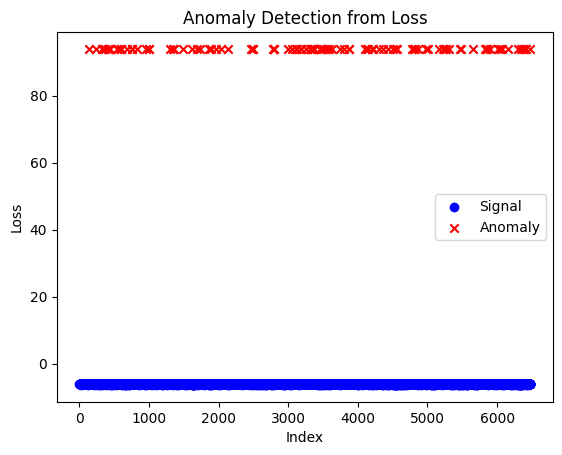

In [ ]:
# Define Threshold
threshold = 3*abs(test_loss)

# Differentiate signal and anomaly
signal_index=np.where(losses<threshold)
signal_loss=losses[signal_index]

anomaly_index=np.where(losses>=threshold)
anomaly_loss=losses[anomaly_index]


# Plot
fig,ax =plt.subplots()

ax.scatter(signal_index,signal_loss,color='blue',label='Signal')
ax.scatter(anomaly_index,anomaly_loss,color='red',marker='x',label='Anomaly')

ax.set_xlabel('Index')
ax.set_ylabel('Loss')
ax.legend(loc='center right')
ax.set_title('Anomaly Detection from Loss')

plt.show()


In [ ]:
Y_true=Y_test_with_bg.numpy()
Y_pred=np.zeros(len(Y_true))

for i in range(len(Y_pred)):
  if(losses[i]>=threshold):
    Y_pred[i] = 0
  else:
    Y_pred[i] = 1


Y_pred
total_predicted_anomaly=np.count_nonzero(Y_pred==0)
score=roc_auc_score(Y_true,Y_pred)

print("Total Anomalies deteted: ",total_predicted_anomaly)
print("ROC AUC Score: ",score)

Total Anomalies deteted:  100
ROC AUC Score:  1.0
